# 如何使用 Intel OpenVINO 及 Ultralytics YOLOv11 完成姿態估測
by Jack OmniXRI, 2024/10/15

本程式主要包含下列幾大步驟。  
1. 原始 YOLOv11 推論結果  
2. 轉換到 OpenVINO IR推論結果  
3. 經過 NNCF 壓縮優化推論結果
4. 使用基準測試工具進行比較  
5. 連續影片推論展示

如果想要在本機端上運行本範例，可參考Github提供的「[安裝步驟](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide)」來完成。

原始程式及進階說明：  
https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/yolov11-optimization/yolov11-keypoint-detection.ipynb


## 1. 原始 YOLOv11 推論結果



### 1.1 安裝 Intel OpenVINO 、 Ultralytics(YOLOv11) 及必要套件包
下載及安裝 OpenVINO, NNCF, PyTorch, Ultralytic(YOLOv11), OpenCV 等相關套件包。  
註：由於 OpenVINO 在 Colab 環境下只能在 Intel Xeon CPU 下運行，所以這裡安裝的 PyTorch 是 CPU 版本。

In [1]:
%pip install -q "openvino>=2024.0.0" "nncf>=2.9.0"
%pip install -q "protobuf==3.20.*" "torch>=2.1" "torchvision>=0.16" "ultralytics==8.3.0" tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 13.0 MB/s eta 0:00:00


### 1.2 下載必要函式庫並引入
下載 notebook_utils.py 到暫存區，並引入 download_file, VideoPlayer, device_widge 函式庫。

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, VideoPlayer, device_widget

### 1.3 下載測試用影像
下載網路上影像檔 intel_rnb.jpg，可自行替換 url 後影像來源路徑。

In [3]:
# Download a test sample
IMAGE_PATH = Path("./data/intel_rnb.jpg")
download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)

data/intel_rnb.jpg:   0%|          | 0.00/288k [00:00<?, ?B/s]

PosixPath('/content/data/intel_rnb.jpg')

### 1.4 指定推論用模型名稱並下載
建立模型名稱清單，可使用下拉盒式選取，預設名稱為為第[0]個，yolo11n-pose。  
這裡可支援 yolov8 及 yolov11 模型名稱，n, s, m, l, x 分別代表模型的大小，從最小到最大，越小推論速度越快但精度略差，反之越大則越慢但精度會提高一些，可依實際需求調整。  

In [4]:
import ipywidgets as widgets

model_id = [
    "yolo11n-pose",
    "yolo11s-pose",
    "yolo11m-pose",
    "yolo11l-pose",
    "yolo11x-pose",
    "yolov8n-pose",
    "yolov8s-pose",
    "yolov8m-pose",
    "yolov8l-pose",
    "yolov8x-pose",
]

model_name = widgets.Dropdown(options=model_id, value=model_id[0], description="Model")

model_name

Dropdown(description='Model', options=('yolo11n-pose', 'yolo11s-pose', 'yolo11m-pose', 'yolo11l-pose', 'yolo11…

### 1.5 實例化 YOLO 並測試推論

依上一步驟取得之模型名稱下載模型並實例化成 pose_model  
接著直接使用該模型對先前指定好的影像進行推論，並取得姿態（關節點）結果 res （包含物件外框、類別及置信度）繪製在影像上。  
另外會輸出總時間及各步驟工作所耗費時間，包含前處理（影像轉換等）、推論（姿態估測）及後處理（輸出數值及繪製結果）。  

註：理論上如果只是想取得姿態估測結果，到這一步就可結束了。但這裡可先記下工作耗時及置信度，方便後面和經過 OpenVINO 處理過的內容作比較。  




Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.97M/5.97M [00:00<00:00, 46.6MB/s]



image 1/1 /content/data/intel_rnb.jpg: 480x640 1 person, 529.1ms
Speed: 23.2ms preprocess, 529.1ms inference, 33.4ms postprocess per image at shape (1, 3, 480, 640)


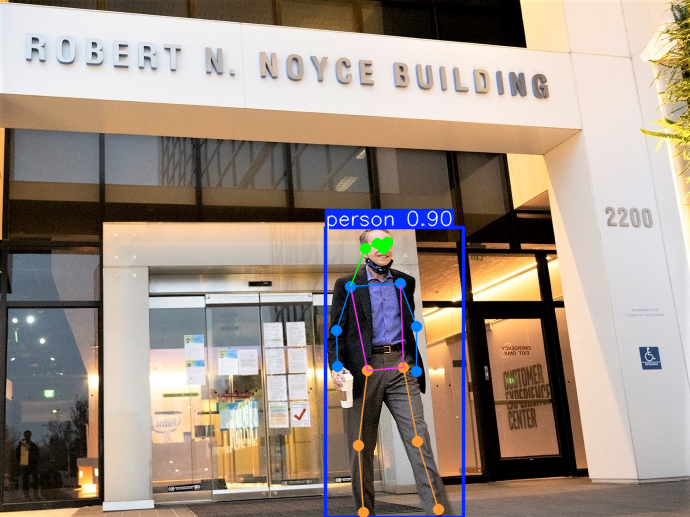

In [5]:
from PIL import Image
from ultralytics import YOLO

POSE_MODEL_NAME = model_name.value

pose_model = YOLO(f"{POSE_MODEL_NAME}.pt")
label_map = pose_model.model.names

res = pose_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

## 2. 轉換到 OpenVINO IR推論結果


### 2.1 將模型轉換成 OpenVINO IR 格式
Ultralytics 本來就有支援將模型輸出成 Intel OpenVINO IR(xml + bin) 格式，只要執行下列程式即可。  
轉換好的模型會存放在 /yolo11n-pose_openvino_model/ 路徑下。這裡仍保持原有 FP32 資料格式。

註：這裡要保留動態形狀（Dynamic Shape）設定為 True，方便後續工作。

In [6]:
# object detection model
pose_model_path = Path(f"{POSE_MODEL_NAME}_openvino_model/{POSE_MODEL_NAME}.xml")
if not pose_model_path.exists():
    pose_model.export(format="openvino", dynamic=True, half=True)

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolo11n-pose.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 56, 8400) (6.0 MB)

OpenVINO: starting export with openvino 2024.4.0-16579-c3152d32c9c-releases/2024/4...
OpenVINO: export success ✅ 8.5s, saved as 'yolo11n-pose_openvino_model/' (6.0 MB)

Export complete (9.5s)
Results saved to /content
Predict:         yolo predict task=pose model=yolo11n-pose_openvino_model imgsz=640 half 
Validate:        yolo val task=pose model=yolo11n-pose_openvino_model imgsz=640 data=/ultralytics/ultralytics/cfg/datasets/coco-pose.yaml half 
Visualize:       https://netron.app


### 2.2 選擇推論裝置
在 Google Colab 上只能選 CPU ，在本機端則還可選用Intel GPU（內顯）來提升推論速度。  不過一般為了方便，可直接設為 AUTO 讓系統自行選用即可。  

In [7]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### 2.3 測試單張影像
這裡的測試影像沿用步驟1.3，接著測試轉成 Intel OpenVINO IR 格式的模型是否能正確推論。  
結果正確，且推論時間可減少一半以上，推論精度仍接近原來水準。  


Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Loading yolo11n-pose_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /content/data/intel_rnb.jpg: 640x640 1 person, 187.4ms
Speed: 3.4ms preprocess, 187.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


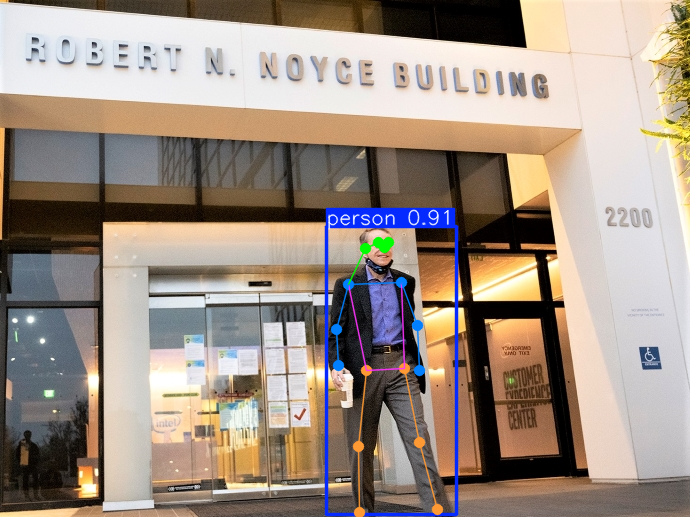

In [8]:
import openvino as ov # 引入 OpenVINO 函式庫

core = ov.Core() # 配置 OpenVINO 核心
pose_ov_model = core.read_model(pose_model_path) # 讀取推論用模型

ov_config = {}

if device.value != "CPU":
    pose_ov_model.reshape({0: [1, 3, 640, 640]})

if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

pose_compiled_model = core.compile_model(pose_ov_model, device.value, ov_config) # 進行模型編譯

pose_model = YOLO(pose_model_path.parent, task="pose")

if pose_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
    args = {**pose_model.overrides, **custom}
    pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
    pose_model.predictor.setup_model(model=pose_model.model)

pose_model.predictor.model.ov_compiled_model = pose_compiled_model # 指定 OpenVINO 編譯好的模型


res = pose_model(IMAGE_PATH) # 進行推論取得結果
Image.fromarray(res[0].plot()[:, :, ::-1]) # 繪製結果

## 3. 經過 NNCF 壓縮優化推論結果
[NNCF](https://github.com/openvinotoolkit/nncf)  是 OpenVINO 作為模型優化的重要工具， 它提供了多種模型壓縮及優化方式，這裡僅使用到參數量化(Quantization)，即將 FP32 轉換到 INT8。  


### 3.1 指定是否量化
預設 to_quantize value 為 True，即要啟用量化。  

In [9]:
import ipywidgets as widgets

int8_model_pose_path = Path(f"{POSE_MODEL_NAME}_openvino_int8_model/{POSE_MODEL_NAME}.xml")
quantized_pose_model = None

to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

### 3.2 不啟用量化處理方式
若不啟用量化則需使用 skip_kernel_extension 模組來協助略過部份工作。  

In [10]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### 3.3 產生 NNCF 所需資料集
下載校正用資料，並設定轉換函式，產生 NNCF 所需資料集。  
此步驟需較長時間，請耐心等候。  

In [11]:
%%skip not $to_quantize.value

import nncf
from typing import Dict

from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.utils import check_det_dataset
from ultralytics.models.yolo.pose import PoseValidator
from ultralytics.utils.metrics import OKS_SIGMA

if not int8_model_pose_path.exists():

    DATA_URL = "https://ultralytics.com/assets/coco8-pose.zip"
    CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco8-pose.yaml"

    OUT_DIR = DATASETS_DIR

    DATA_PATH = OUT_DIR / "val2017.zip"
    CFG_PATH = OUT_DIR / "coco8-pose.yaml"

    download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
    download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

    if not (OUT_DIR / "coco8-pose/labels").exists():
        with ZipFile(DATA_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR)

    args = get_cfg(cfg=DEFAULT_CFG)
    args.data = "coco8-pose.yaml"

    pose_validator = PoseValidator(args=args)
    pose_validator.data = check_det_dataset(args.data)
    pose_validator.stride = 32
    pose_data_loader = pose_validator.get_dataloader(OUT_DIR / "coco8-pose", 1)

    pose_validator.is_coco = True
    pose_validator.names = label_map
    pose_validator.metrics.names = pose_validator.names
    pose_validator.nc = 1
    pose_validator.sigma = OKS_SIGMA


    def transform_fn(data_item:Dict):
        """
        Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
        Parameters:
           data_item: Dict with data item produced by DataLoader during iteration
        Returns:
            input_tensor: Input data for quantization
        """
        input_tensor = pose_validator.preprocess(data_item)['img'].numpy()
        return input_tensor


    quantization_dataset = nncf.Dataset(pose_data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, openvino


/content/datasets/val2017.zip:   0%|          | 0.00/334k [00:00<?, ?B/s]

/content/datasets/coco8-pose.yaml:   0%|          | 0.00/552 [00:00<?, ?B/s]

100%|██████████| 755k/755k [00:00<00:00, 10.0MB/s]
val: Scanning /content/datasets/coco8-pose/labels/train... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 945.62it/s]

val: New cache created: /content/datasets/coco8-pose/labels/train.cache


### 3.4 使用 NNCF 進行模型量化  
開始進行量化，產生新 INT8 模型。  
此步驟需較長時間，請耐心等候。

In [12]:
%%skip not $to_quantize.value

if not int8_model_pose_path.exists():

    ignored_scope = nncf.IgnoredScope(  # post-processing
        subgraphs=[
            nncf.Subgraph(inputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat",
                                  f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_1",
                                  f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_2",
                                 f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_7"],
                          outputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_9"])
        ]
    )

    # Detection model
    quantized_pose_model = nncf.quantize(
        pose_ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
        ignored_scope=ignored_scope
    )
    print(f"Quantized keypoint detection model will be saved to {int8_model_pose_path}")
    ov.save_model(quantized_pose_model, str(int8_model_pose_path))

INFO:nncf:116 ignored nodes were found by subgraphs in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 140 __module.model.23/aten::cat/Concat
INFO:nncf:Not adding activation input quantizer for operation: 149 __module.model.23/aten::view/Reshape_3
INFO:nncf:Not adding activation input quantizer for operation: 297 __module.model.23/aten::cat/Concat_1
INFO:nncf:Not adding activation input quantizer for operation: 311 __module.model.23/aten::view/Reshape_4
INFO:nncf:Not adding activation input quantizer for operation: 418 __module.model.23/aten::cat/Concat_2
INFO:nncf:Not adding activation input quantizer for operation: 422 __module.model.23/aten::view/Reshape_5
INFO:nncf:Not adding activation input quantizer for operation: 151 __module.model.23/aten::cat/Concat_7
INFO:nncf:Not adding activation input quantizer for operation: 163 __module.model.23/aten::view/Reshape_9
INFO:nncf:Not adding activation input quantizer for operation: 177 __module.model.23/aten::sl

Output()

Output()

Quantized keypoint detection model will be saved to yolo11n-pose_openvino_int8_model/yolo11n-pose.xml


### 3.5 測試單張影像
這裡的測試影像沿用步驟1.3，接著測試經 NNCF 量化後的模型是否能正確推論。  
結果正確，推論精度仍接近原來水準。  

In [13]:
%%skip not $to_quantize.value

device

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Loading yolo11n-pose_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /content/data/intel_rnb.jpg: 640x640 1 person, 285.1ms
Speed: 4.3ms preprocess, 285.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


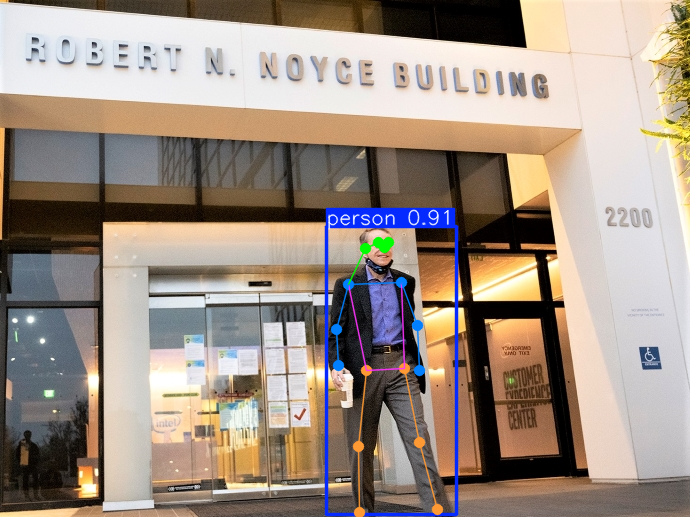

In [14]:
%%skip not $to_quantize.value

if quantized_pose_model is None:
    quantized_pose_model = core.read_model()

ov_config = {}
if device.value != "CPU":
    quantized_pose_model.reshape({0: [1, 3, 640, 640]})

if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

quantized_pose_compiled_model = core.compile_model(quantized_pose_model, device.value, ov_config)

pose_model = YOLO(pose_model_path.parent, task="pose")

if pose_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
    args = {**pose_model.overrides, **custom}
    pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
    pose_model.predictor.setup_model(model=pose_model.model)

pose_model.predictor.model.ov_compiled_model = pose_compiled_model

res = pose_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## 4. 使用基準測試工具進行比較

### 4.1 使用基準測試工具測試
[Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) 是 OpenVINO 提供的一組工具程式，方便連續測試用，可指定不同推論裝置、連續工作時間（預設60秒，可加 -t 指定秒數），再去計算每秒可執行次數及每次推論所需最小、最大及平均時間，方便進行性能比較。這和單張略微不同，可省去許多共同時間，如模型載入、編譯等。  
若在本機端執行時可將裝置設為 GPU 進行比較。  

In [15]:
%%skip not $to_quantize.value

device

### 4.2 使用 FP32 模型推論

In [16]:
if int8_model_pose_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $pose_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.4.0-16579-c3152d32c9c-releases/2024/4
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.4.0-16579-c3152d32c9c-releases/2024/4
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 54.47 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_9) : f32 / [...] / [?,56,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

### 4.3 使用 INT8 模型推論

In [17]:
if int8_model_pose_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_pose_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.4.0-16579-c3152d32c9c-releases/2024/4
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.4.0-16579-c3152d32c9c-releases/2024/4
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 60.62 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_9) : f32 / [...] / [1,56,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batc

## 5. 連續影片推論展示



### 5.1 建立推論函式
run_keypoint_detection 這個函式包括模型載入、影像載入、推論及繪製結果

In [18]:
import collections
import time
from IPython import display
import cv2
import numpy as np


def run_keypoint_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=pose_model,
    device=device.value,
):
    player = None

    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})

    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

    compiled_model = core.compile_model(model, device, ov_config)

    if pose_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**seg_model.overrides, **custom}
        pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
        pose_model.predictor.setup_model(model=pose_model.model)

    pose_model.predictor.model.ov_compiled_model = compiled_model

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results
            input_image = np.array(frame)

            start_time = time.time()

            detections = pose_model(input_image)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### 5.2 取得影片進行姿態估測
呼叫 run_keypoint_detection 進行推論，可依需要改變影片來源、推論裝置及模型。    
* 若在本地端運行時，將 Source 改成 0 ，就可直接支援本機（桌機或筆電)上的第1部網路攝影機。若有多部則修改為 1 到 N 。  
* 若在 Colab 上遇到畫面閃爍問題時，可將 use_popup 設為 True 來改善。  
* 若想多次測試不同影片、裝置（CPU / GPU / AUTO）或模型(pose_ov_model / quantized_pose_model)，可直接修改參數，單獨運行本格程式即可，不用全部程式重新運行。  


In [19]:
VIDEO_SOURCE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4"

In [23]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

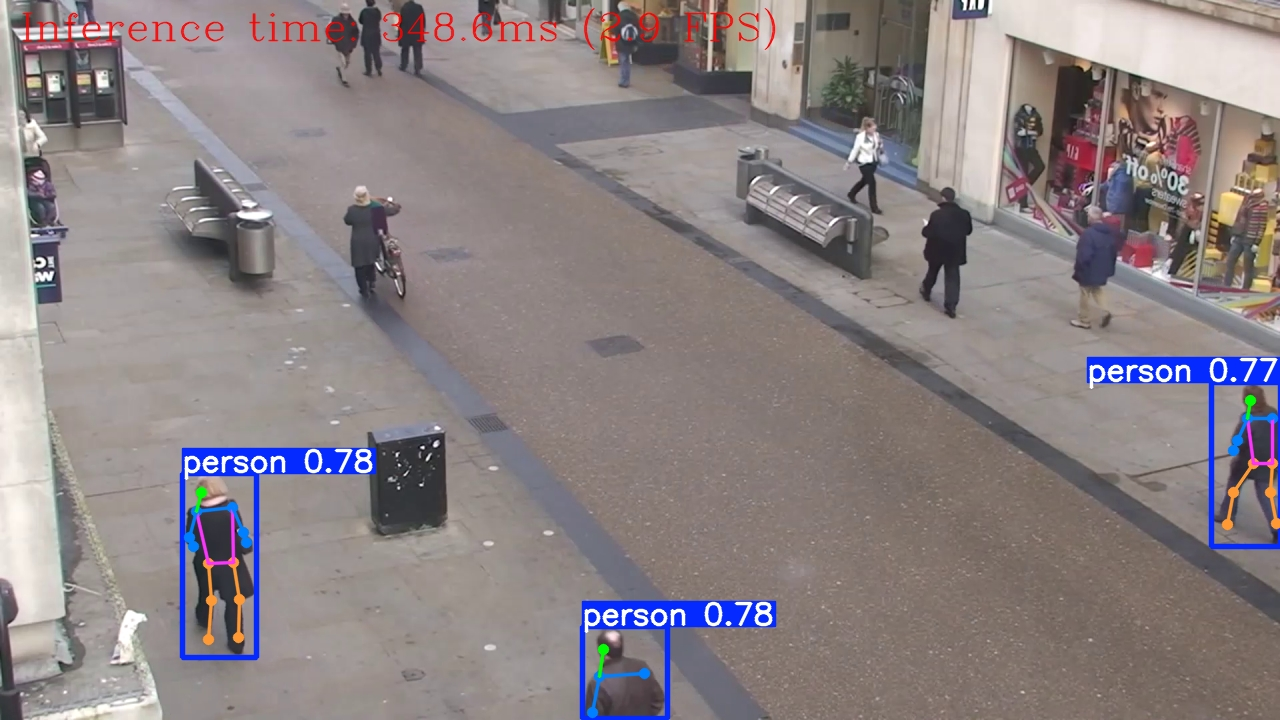

Source ended


In [26]:
run_keypoint_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=pose_ov_model, # pose_ov_model, quantized_pose_model
    device=device.value,
)